### Desde https://causalnex.readthedocs.io/

# Tutorial CausalNex 


Este tutorial es un ejemplo de uso de CausalNex para estimar si un estudiante aprobabará o suspenderá un examen, basándose en características como relaciones familiares, soporte escolar y otros. Se usará el dataset de [Student Performance](https://archive.ics.uci.edu/ml/datasets/Student+Performance) publicado en [UCI Machine Learning Repository.](http://archive.ics.uci.edu/ml/index.php)

## Structure Learning

Defining the structure of a Bayesian Network (BN) model can be done based on machine learning, domain knowledge, or a combination of both, where experts and algorithms contribute as equal partners.

Regardless of the approach, it is important to validate the structure by evaluating the BN - this will be covered later in the tutorial. In this section, we will focus on how to define a structure.



## Structure from Domain Knowledge

We can manually define a structure model by specifying the relationships between different features.

First, we must create an empty structure model.

In [1]:
from causalnex.structure import StructureModel

sm=StructureModel()
sm

Next, we can specify the relationships between features. For example, let’s assume that experts tell us the following causal relationships are known (G1 is grade in semester 1): * health -> absences * health -> G1

We can add these relationships into our structure model:

In [2]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

## Visualising the Structure

We can examine a StructureModel by looking at the output of sm.edges

In [3]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

but it can often be more intuitive to visualise it. CausalNex provides a plotting module that allows us to do this.

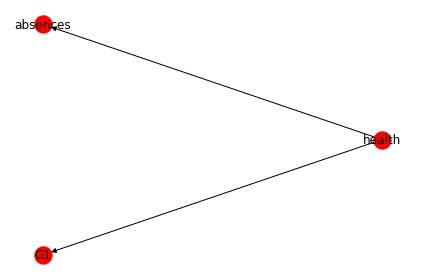

In [5]:
%matplotlib inline
from causalnex.plots import plot_structure

_, _, _ = plot_structure(sm)

## Learning the Structure
As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the [NOTEARS](https://arxiv.org/abs/1803.01422) algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

## Preparing the Data for Structure Learning

In [8]:
import pandas as pd
data=pd.read_csv('data/student-por.csv', delimiter=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Looking at the data, we can see that features consist of numeric and non-numeric columns. We can drop sensitive features such as sex that we do not want to include in our model.

In [9]:
drop_col=['school', 'sex', 'age', 'Mjob', 'Fjob', 'reason', 'guardian']
data=data.drop(columns=drop_col)
data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13
